In [54]:
import pandas as pd
import math
import numpy as np
import sklearn
import requests
from bs4 import BeautifulSoup
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm, preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lxml import html
import urllib.request
from selenium import webdriver
import selenium
import time
import statsmodels.formula.api as sm
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score
import re

# Obtaining a database

In [47]:
df = pd.read_csv('epldata_final.csv')

In [48]:
df.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [49]:
df.dtypes

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object

In [8]:
# Web scarping to obtain all prices for which each player was sold
df_all = []
for x in range(7, 18):
    if x < 10:
        url = 'https://en.wikipedia.org/wiki/List_of_English_football_transfers_summer_200{}'.format(x)
    else:
        url = 'https://en.wikipedia.org/wiki/List_of_English_football_transfers_summer_20{}'.format(x)
    html = requests.get(url).content
    soup = BeautifulSoup(html, "lxml")
    text = [element.text.strip().replace(',', '').replace('\n\n\n', ',').replace('\n\n', ',').replace('\n', ',') for element in soup.find_all('table',{'class':'wikitable sortable'})]
    ans = text[0].split(',')
    l = []
    for x in range(5, len(ans),5):
        l.append(ans[x:x+5])
    df_all.append(l)

In [10]:
df7 = pd.DataFrame(df_all[0])[[1, 4]]
df7 = df7.rename({1: 'name', 4: 'price1'}, axis = 1)
df8 = pd.DataFrame(df_all[1])[[1, 4]]
df8 = df8.rename({1: 'name', 4: 'price2'}, axis = 1)
df9 = pd.DataFrame(df_all[2])[[1, 4]]
df9 = df9.rename({1: 'name', 4: 'price3'}, axis = 1)
df10 = pd.DataFrame(df_all[3])[[1, 4]]
df10 = df10.rename({1: 'name', 4: 'price4'}, axis = 1)
df11 = pd.DataFrame(df_all[4])[[1, 4]]
df11 = df11.rename({1: 'name', 4: 'price5'}, axis = 1)
df12 = pd.DataFrame(df_all[5])[[1, 4]]
df12 = df12.rename({1: 'name', 4: 'price6'}, axis = 1)
df13 = pd.DataFrame(df_all[6])[[1, 4]]
df13 = df13.rename({1: 'name', 4: 'price7'}, axis = 1)
df14 = pd.DataFrame(df_all[7])[[1, 4]]
df14 = df14.rename({1: 'name', 4: 'price8'}, axis = 1)
df15 = pd.DataFrame(df_all[8])[[1, 4]]
df15 = df15.rename({1: 'name', 4: 'price9'}, axis = 1)
df16 = pd.DataFrame(df_all[9])[[1, 4]]
df16 = df16.rename({1: 'name', 4: 'price10'}, axis = 1)
df17 = pd.DataFrame(df_all[10])[[1, 4]]
df17 = df17.rename({1: 'name', 4: 'price11'}, axis = 1)

In [50]:
transfer = pd.read_csv('transfer.csv')

In [51]:
# Webscraping to obtain goals, apps, wins, assits for each player
page = requests.get('https://www.premierleague.com/clubs?se=79')
tree = html.fromstring(page.content)

In [52]:
#Using the page's CSS classes, extract all links pointing to a team
linkLocation = tree.cssselect('.indexItem')
teamLinks = []

for i in range(0,20):
    
    #Find page link is going to.
    temp = linkLocation[i].attrib['href']
    #Add the link to the website domain.
    temp = "http://www.premierleague.com/" + temp + '?se=79'
    #Change the link text so that it points to the squad list.
    temp = temp.replace("overview", "squad")
    teamLinks.append(temp)

In [55]:
playerLink1 = []
playerLink2 = []


for i in range(len(teamLinks)):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('window-size=1920x1080');
    driver = webdriver.Chrome('/Users/grsanchez/Downloads/chromedriver-2', options=chrome_options)
    driver.get(teamLinks[i])
    time.sleep(10)
    squadPage=driver.page_source
    soup = BeautifulSoup(squadPage, 'html.parser')
    playerLocation = soup.findAll('a', class_=re.compile("playerOverviewCard"))
    for i in range(len(playerLocation)):

        #Save the link, complete with domain.
        playerLink1.append('http:' + playerLocation[i]['href'])
        #For the second link, change the page from player overview to stats
        playerLink2.append(playerLink1[i].replace("overview", "stats"))

    driver.quit()

In [56]:
data = []
for i in range(len(playerLink1)):

    #...download and process the two pages collected earlier...
    playerPage1 = requests.get(playerLink1[i])
    playerTree1 = html.fromstring(playerPage1.content)
    playerPage2 = requests.get(playerLink2[i])
    playerTree2 = html.fromstring(playerPage2.content)

    #...find the relevant datapoint for each player, starting with name...
    try:
        tempName = str(playerTree1.cssselect('div.name')[0].text_content())
    except IndexError:
        tempName = str('Nan')
    
    #...and team, but if there isn't a team, return "BLANK"...
    try:
        tempGoals = playerTree2.cssselect('.statgoals')[0].text_content()
        tempGoals = int(re.search(r'\d+', tempGoals).group())
    except IndexError:
        tempGoals = float('NaN')
    
    #...and age, but if this isn't there, leave a blank 'no number' number...
    try:
        tempAssists = playerTree2.cssselect('.statgoal_assist')[0].text_content()
        tempAssists = int(re.search(r'\d+', tempAssists).group())
    except IndexError:
        tempAssists = float('NaN')

    #...and appearances. This is a bit of a mess on the page, so tidy it first...
    try:
        tempApps = playerTree2.cssselect('.statappearances')[0].text_content()
        tempApps = int(re.search(r'\d+', tempApps).group())
    except IndexError:
        tempApps = float('NaN')

    #...and height. Needs tidying again...
    try:
        tempWins = playerTree2.cssselect('.statwins')[0].text_content()
        tempWins = int(re.search(r'\d+', tempWins).group())
    except IndexError:
        tempWins = float('NaN')
    
    data.append([tempName, tempGoals, tempAssists, tempApps, tempWins])
     

In [57]:
stats = pd.DataFrame(data, columns = ['name', 'goals', 'assists', 'apps', 'wins'])

In [58]:
# Replacing special characters in the names of football players obtained. This is important so a merge on player names
# is possible.
name_mod = []
for i in stats.name:
    i = i.replace('Ãzil', 'Ozil').replace('Ã©', 'e').replace('Ã¯', 'i').replace('Ã£', 'a').replace('Ãn', 'in').replace('Ã©', 'e').replace('Ã¡', 'a').replace('Ã¤', 'a').replace('Ã«', 'e').replace('Ã¼', 'u').replace('Ã¸', 'o').replace('Ã¶', 'o').replace('Ã ', 'a').replace('Ã¨', 'e').replace('Ã', 'i').replace('­', '').replace('iº', 'u')
    name_mod.append(i)

In [59]:
stats.name = name_mod

In [60]:
players = df.merge(stats, how = 'left', on = 'name')
players['price'] = players['market_value']
players.drop('market_value', axis = 1, inplace = True)
players.goals = players.goals/players.apps
players.assists = players.assists/players.apps
players.drop('apps', axis = 1, inplace = True)
players.assists.fillna(0.1, inplace = True)
players.goals.fillna(0.08, inplace = True)

In [61]:
# All the previous prices at which players were sold also contained whether they were on loan or whether they have
# been in a team since the youth academy. If a player was on loan I decided that it meant that the player was
# underperforming in his new club hence his new market value at that point is 70% of his previous market-value
# For those players playing in a team since the youth academy, it probably meant they were young so i just applied
# a price of 400,000 to those players.

fees_all = []
for c in range(len(transfer)):
    tran = list(transfer.iloc[c][1:].values)
    fees = []
    for x in range(len(tran)):
        if tran[x] == 'loan':
            try:
                if type(tran[x-1]) == str:
                    fees.append((0.7*float(tran[x-1]))/10**6)
            except:
                fees.append(0.25)
        elif tran[x] == 'free':
            fees.append(0.20)
        elif tran[x] == 'youth':
            fees.append(0.4)
        elif type(tran[x]) == str:
            fees.append(float(tran[x])/10**6)
    fees_all.append(fees)

# Here I obtain information about the previous market-values of a player. I take a mean, a max, and whether the player
# is going up or down in price.
fee_stat = []
for fee in fees_all:
    try:
        maximum = max(fee)
        if fee[len(fee)-1] > fee[len(fee)-2]:
            x = 1
        else:
            x = 0
    except:
        x = 0.5
        maximum = 0
    fee_stat.append([np.mean(fee), maximum, x])
    
transfer_stats = pd.concat([transfer['name'], pd.DataFrame(fee_stat, columns = ['mean_fee', 'max_fee', 'up_do'])], axis=1)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [62]:
players = players.merge(transfer_stats, how = 'left', on = 'name')

In [63]:
players.dropna(inplace = True)
players.reset_index(inplace = True, drop = True)

In [64]:
players['fpl_sel'] = [float(i.strip('%'))/100 for i in players['fpl_sel']] 

In [65]:
players = players.sample(frac=1)
players.reset_index(inplace = True, drop=True)

In [66]:
players.to_csv(r'\Users\grsanchez\labs\datamad0119\final-project', index=False)

In [67]:
players = pd.read_csv('playersCSV')

# Applying different models to database

In [68]:
players.head()

,name,club,age,position,position_cat,page_views,fpl_value,fpl_sel,fpl_points,region,...,club_id,big_club,new_signing,goals,assists,wins,price,mean_fee,max_fee,up_do
0,Markus Suttner,Brighton+and+Hove,30,LB,3,23,4.5,0.002,0,2.0,...,3,0,0,0.090909,0.038961,44.0,2.0,2.3400,4.05,1.0
1,Ross Barkley,Everton,23,AM,1,1413,7.5,0.007,144,1.0,...,7,0,0,0.046784,0.105263,82.0,25.0,9.6300,15.21,1.0
2,Dusan Tadic,Southampton,28,LW,1,458,6.5,0.049,108,2.0,...,14,0,0,0.080000,0.100000,0.0,17.0,0.4000,0.40,0.0
3,Sadio Mane,Liverpool,25,LW,1,3219,9.5,0.053,156,4.0,...,10,1,1,0.359813,0.130841,119.0,40.0,20.4600,37.08,1.0
4,Nathan Ake,Bournemouth,22,CB,3,1274,5.0,0.115,55,2.0,...,2,0,0,0.044444,0.200000,27.0,8.0,4.4488,20.52,1.0


In [69]:
players.describe()

,age,position_cat,page_views,fpl_value,fpl_sel,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing,goals,assists,wins,price,mean_fee,max_fee,up_do
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000
mean,26.569712,2.163462,842.228365,5.549279,0.034351,58.747596,1.990385,0.033654,3.115385,9.312500,0.362981,0.141827,0.083536,0.093429,49.165865,12.135817,6.103616,11.903966,0.596154
std,3.900565,1.009455,979.895681,1.439745,0.057905,55.320327,0.966875,0.180554,1.263445,5.494658,0.481438,0.349293,0.088623,0.082126,47.151015,12.955697,6.492683,13.137510,0.491258
min,17.000000,1.000000,9.000000,4.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.005000,0.005000,0.000000
25%,24.000000,1.000000,246.000000,4.500000,0.002750,4.000000,1.000000,0.000000,2.000000,5.000000,0.000000,0.000000,0.021739,0.009524,1.000000,3.000000,1.366250,2.575000,0.000000
50%,27.000000,2.000000,522.000000,5.000000,0.011000,51.000000,2.000000,0.000000,3.000000,9.000000,0.000000,0.000000,0.073684,0.100000,35.000000,7.500000,4.059625,7.350000,1.000000
75%,29.000000,3.000000,1066.750000,6.000000,0.035250,95.250000,2.000000,0.000000,4.000000,13.000000,1.000000,0.000000,0.088000,0.128049,86.000000,17.000000,8.566438,15.300000,1.000000
max,38.000000,4.000000,7664.000000,12.500000,0.450000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000,0.426230,0.325000,280.000000,75.000000,37.600000,75.000000,1.000000


In [70]:
players.dtypes

name             object
club             object
age               int64
position         object
position_cat      int64
page_views        int64
fpl_value       float64
fpl_sel         float64
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
goals           float64
assists         float64
wins            float64
price           float64
mean_fee        float64
max_fee         float64
up_do           float64
dtype: object

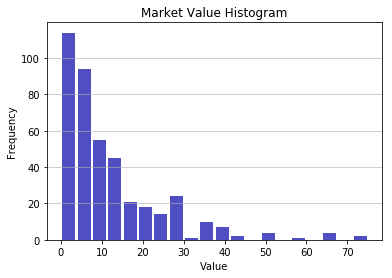

In [71]:
# Distribution of player's market-values
n, bins, patches = plt.hist(x=players.price, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Market Value Histogram')
maxfreq = n.max()

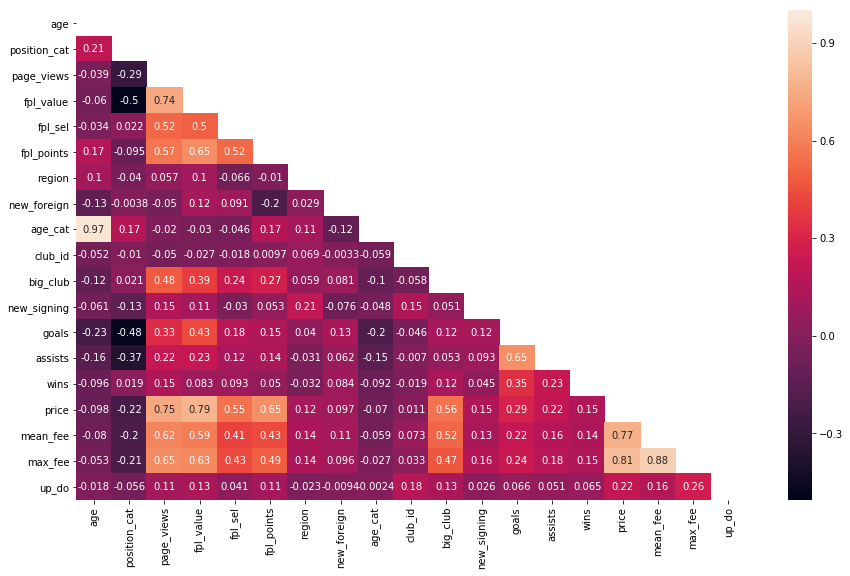

In [72]:
# Checking for correlation between features
mask = np.zeros_like(players.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(15,9))
sns.heatmap(players.corr(), mask = mask, annot=True)

In [73]:
#Multiple regression
X = players.drop(['name', 'club', 'age', 'position', 'nationality', 'price'], axis = 1).values
y = players.price.values

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [75]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [76]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [77]:
y_pred = regressor.predict(X_test)
diff = []
for M, A in list(zip(y_pred, y_test)):
    diff.append(abs(M-A))
diff_lr = np.mean(diff)  

In [78]:
X1 = sc_X.transform(X)
y_pred1 = regressor.predict(X1)
pred = []
for M, A in list(zip(y_pred1, y)):
    pred.append([M, A])
mlr_c = pd.DataFrame(pred, columns = ['Model', 'Actual'])
mlr_c.head()

,Model,Actual
0,1.507649,2.0
1,23.660156,25.0
2,7.697544,17.0
3,41.506061,40.0
4,16.087469,8.0


In [79]:
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)
accuracy_lr = accuracies.mean()
std_lr = accuracies.std()
score_lr = regressor.score(X_train, y_train)

In [80]:
# Random forest regression
X = players.drop(['name', 'club', 'age', 'position', 'nationality', 'price', 'wins'], axis = 1).values
y = players.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [81]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [82]:
regressor = RandomForestRegressor(n_estimators = 300, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [83]:
y_pred = regressor.predict(X_test)
diff = []
for M, A in list(zip(y_pred, y_test)):
    diff.append(abs(M-A))
diff_rfr = np.mean(diff)  

In [84]:
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)
accuracy_rfr = accuracies.mean()
std_rfr = accuracies.std()
score_rfr = regressor.score(X_train, y_train)

In [85]:
X1 = sc_X.transform(X)
y_pred1 = regressor.predict(X1)

In [86]:
pred = []
for M, A in list(zip(y_pred1, y)):
    pred.append([M, A])
rfr_c1 = pd.DataFrame(pred, columns = ['Model', 'Actual'])
rfr_c1.head()

,Model,Actual
0,2.094167,2.0
1,18.666667,25.0
2,13.271667,17.0
3,42.153333,40.0
4,14.516667,8.0


In [87]:
from sklearn.metrics import r2_score
print('r2_score: ', r2_score(rfr_c1.Actual, rfr_c1.Model))

r2_score:  0.9442109722135561


In [88]:
from sklearn.metrics import mean_squared_error

print('mean_squared_error: ', mean_squared_error(rfr_c1.Actual, rfr_c1.Model))

mean_squared_error:  9.34168311698718


In [89]:
# OLS regression
# Using backwards elimination to come up with the best model. Techinique employed of least squares.
X = np.append(arr = np.ones((416, 1)).astype(int), values = X, axis = 1)
X_opt = X[:, [0, 1, 4, 5,6,7,8,9,10,11,12,13,14,15,16]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     124.4
Date:                Fri, 22 Mar 2019   Prob (F-statistic):          3.38e-136
Time:                        10:15:39   Log-Likelihood:                -1306.8
No. Observations:                 416   AIC:                             2644.
Df Residuals:                     401   BIC:                             2704.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1467      1.427      0.804      0.422      -1.658       3.951
x1            -0.9479      0.334     -2.839      0.005      -1.604      -0.292
x2            28.5676      6.193      4.613      0.000      16.393      40.742
x3             0.0732      0.007     10.477      0.000       0.059       0.087
x4             0.6426      0.306      2.100      0.036       0.041       1.244
x5             5.4350      1.681      3.233      0.001       2.130       8.740
x6            -0.6127      0.241     -2.542      0.011      -1.087      -0.139
x7            -0.0372      0.054     -0.694      0.488      -0.143       0.068
x8             5.0162      0.704      7.123      0.000       3.632       6.401
x9             1.1684      0.852      1.372      0.171      -0.506       2.843
x10            2.3076      4.583      0.504      0.615      -6.702      11.317
x11            1.7177      4.522      0.380      0.704      -7.171      10.607
x12            0.2069      0.098      2.103      0.036       0.013       0.400
x13            0.3682      0.050      7.324      0.000       0.269       0.467
x14            0.9528      0.617      1.544      0.123      -0.260       2.166
==============================================================================
Omnibus:                      133.460   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.008
Skew:                           1.221   Prob(JB):                    5.25e-179
Kurtosis:                       9.434   Cond. No.                     1.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
# rbf model. Linear regression using rbf kernel
X = players.drop(['name', 'club', 'age', 'position', 'nationality', 'price', 'wins'], axis = 1).values
y = players.price.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [91]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [92]:
regressor = svm.SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [93]:
y_pred = regressor.predict(X_test)
diff = []
for M, A in list(zip(y_pred, y_test)):
    diff.append(abs(M-A))
diff_rbf = np.mean(diff)  

In [94]:
X1 = sc_X.transform(X)
y_pred1 = regressor.predict(X1)
pred = []
for M, A in list(zip(y_pred1, y)):
    pred.append([M, A])
rbf_c = pd.DataFrame(pred, columns = ['Model', 'Actual'])
rbf_c.head()

,Model,Actual
0,1.812029,2.0
1,17.290117,25.0
2,7.369341,17.0
3,19.973819,40.0
4,12.246497,8.0


In [95]:
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)
accuracy_rbf = accuracies.mean()
std_rbf = accuracies.std()
score_rbf = regressor.score(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [96]:
model = [['rbf', diff_rbf, accuracy_rbf, std_rbf, score_rbf], ['mlr', diff_lr, accuracy_lr, std_lr, score_lr], ['rfr', diff_rfr, accuracy_rfr, std_rfr, score_rfr]]
columns = ['model', 'avg.diff', 'accuracy', 'accuracy_std', 'score']
models = pd.DataFrame(model, columns = columns)

In [97]:
# Here we can clearly see that the best model is the random forest regression. It has the highest score and lowest
# avg.diff which is postive. Also the accuracy is not too high so no worry about overfitting.
models.sort_values('score', ascending = False)

,model,avg.diff,accuracy,accuracy_std,score
2,rfr,3.251149,0.781785,0.146994,0.976241
1,mlr,4.002414,0.791160,0.077707,0.856896
0,rbf,5.476877,0.458984,0.161395,0.486807


In [98]:
players.head()

,name,club,age,position,position_cat,page_views,fpl_value,fpl_sel,fpl_points,region,...,club_id,big_club,new_signing,goals,assists,wins,price,mean_fee,max_fee,up_do
0,Markus Suttner,Brighton+and+Hove,30,LB,3,23,4.5,0.002,0,2.0,...,3,0,0,0.090909,0.038961,44.0,2.0,2.3400,4.05,1.0
1,Ross Barkley,Everton,23,AM,1,1413,7.5,0.007,144,1.0,...,7,0,0,0.046784,0.105263,82.0,25.0,9.6300,15.21,1.0
2,Dusan Tadic,Southampton,28,LW,1,458,6.5,0.049,108,2.0,...,14,0,0,0.080000,0.100000,0.0,17.0,0.4000,0.40,0.0
3,Sadio Mane,Liverpool,25,LW,1,3219,9.5,0.053,156,4.0,...,10,1,1,0.359813,0.130841,119.0,40.0,20.4600,37.08,1.0
4,Nathan Ake,Bournemouth,22,CB,3,1274,5.0,0.115,55,2.0,...,2,0,0,0.044444,0.200000,27.0,8.0,4.4488,20.52,1.0


# Focusing on random forest regression

In [100]:
# Seperating the market-value of players into bins
#rfr model
rfr_c1['Model'] = np.where(rfr_c1['Model'] > 35, 3, (np.where(rfr_c1['Model'] < 12, 2, 1)))
rfr_c1['Actual'] = np.where(rfr_c1['Actual'] > 35, 3, (np.where(rfr_c1['Actual'] < 12, 2, 1)))

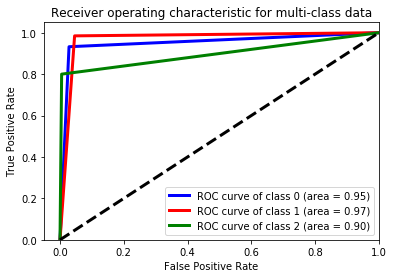

3


In [103]:
# Plot roc curves for all three classes which correspond to the market-value of players.
y_test = label_binarize(rfr_c1['Actual'], classes=[1, 2, 3]) 
y_score = label_binarize(rfr_c1['Model'], classes=[1, 2, 3])
n_classes = y_test.shape[1]
lw = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()
print(y_test.shape[1])

Normalized confusion matrix
[[0.93233083 0.05263158 0.01503759]
 [0.01520913 0.98479087 0.        ]
 [0.2        0.         0.8       ]]


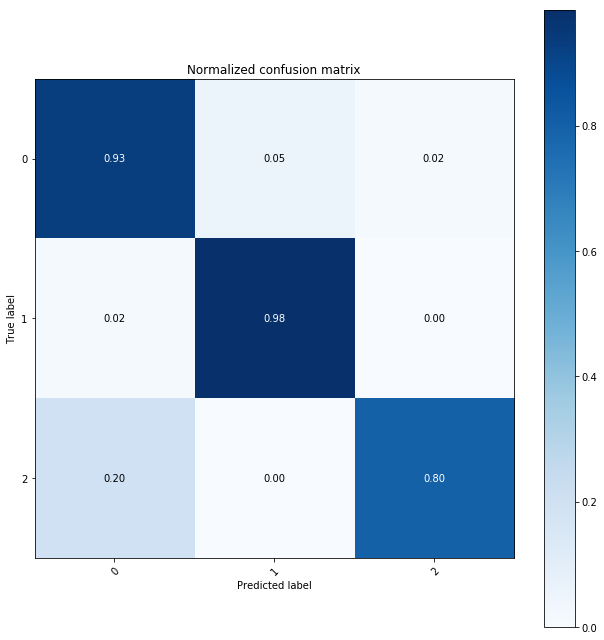

In [105]:
# Plotting confusin matrix
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(rfr_c1['Actual'], rfr_c1['Model'], normalize=True, title=False, cmap=plt.cm.Blues)

In [106]:
# From the data above we can see that the model fails predicting the player's prices of class 2 which correspond
# tp the more expensive players

In [110]:
rf = rfr_c1.loc[(rfr_c1.Actual < 3) & (rfr_c1.Model < 3)]

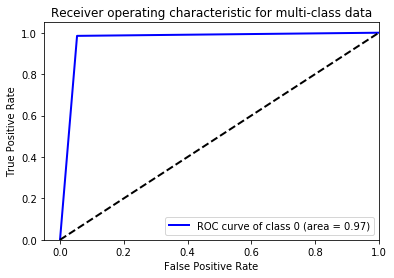

In [111]:
# plotting roc curve for updated model
y_test = label_binarize(rf['Actual'], classes=[1, 2]) 
y_score = label_binarize(rf['Model'], classes=[1, 2])
n_classes = y_test.shape[1] 
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [112]:
# These stats reflect a very positive view of the model. There may be a case of overfitting but i doubt it.
from sklearn.metrics import precision_score, recall_score, f1_score

balanced_score = balanced_accuracy_score(rf.Actual, rf.Model)
score = accuracy_score(rf.Actual, rf.Model)
precision = precision_score(rf.Actual, rf.Model)
recall = recall_score(rf.Actual, rf.Model)
f1_score = f1_score(rf.Actual, rf.Model)

print('Balanced Accuracy Score: ', balanced_score)
print('Accuracy_score: ', score)
print('Precision: ', precision)
print('Recall: ', recall)
print('F-score: ', f1_score)

Balanced Accuracy Score:  0.9656778800104491
Accuracy_score:  0.9720812182741116
Precision:  0.96875
Recall:  0.9465648854961832
F-score:  0.9575289575289575


Normalized confusion matrix
[[0.94656489 0.05343511]
 [0.01520913 0.98479087]]


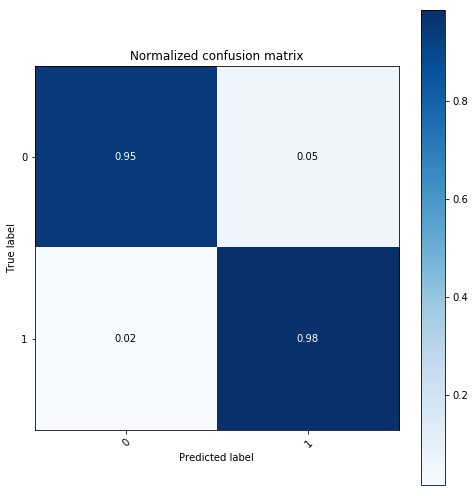

In [113]:
#Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(rf['Actual'], rf['Model'], normalize=True, title=False, cmap=plt.cm.Blues)

In [114]:
# From the model above I can't see any drastic improvements from removing the player's which cost more than 35 million. 

# Final Results

In [115]:
# Given that we saw no improvement in the model, we revert back to the orginal model. It seems to perform quite well. 

In [116]:
pres_fees = pd.concat([players.name, rfr_c1], axis = 1)
pres_fees = pres_fees.sample(frac=1)
pres_fees.reset_index(inplace = True, drop=True)
pres_fees.head(10)

,name,Model,Actual
0,Mason Holgate,2,2
1,Jamie Murphy,2,2
2,Jonathan Hogg,2,2
3,Jordan Pickford,1,1
4,Philip Billing,2,2
5,David Luiz,1,1
6,Fraser Forster,1,1
7,Marko Arnautovic,1,1
8,Jan Vertonghen,1,1
9,Diafra Sakho,2,2


In [117]:
pres_fees['Delta %'] = abs(pres_fees.Model - pres_fees.Actual)*100/pres_fees.Actual

In [118]:
pres_fees.head(10)

,name,Model,Actual,Delta %
0,Mason Holgate,2,2,0.0
1,Jamie Murphy,2,2,0.0
2,Jonathan Hogg,2,2,0.0
3,Jordan Pickford,1,1,0.0
4,Philip Billing,2,2,0.0
5,David Luiz,1,1,0.0
6,Fraser Forster,1,1,0.0
7,Marko Arnautovic,1,1,0.0
8,Jan Vertonghen,1,1,0.0
9,Diafra Sakho,2,2,0.0


In [119]:
# Postive r-2 score. Positve result
from sklearn.metrics import r2_score
print('r2_score: ', r2_score(rfr_c1.Actual, rfr_c1.Model))

r2_score:  0.7138308535938206


In [120]:
# The mean squard erro does not vary that much so that is positive as well.
from sklearn.metrics import mean_squared_error

print('mean_squared_error: ', mean_squared_error(rfr_c1.Actual, rfr_c1.Model))

mean_squared_error:  0.08413461538461539
